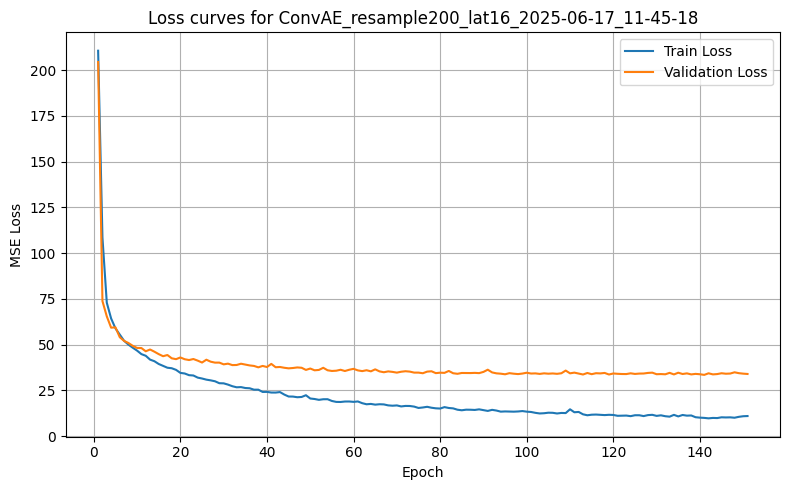

In [10]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    """
    Starting from the current file (if in a script) or cwd (if in a notebook),
    walk upward until you find a directory that contains `marker_dir`.
    """
    # start from __file__ if available (script), else from cwd()
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    # fallback to cwd
    return Path.cwd().resolve()

# 1) Locate project root by looking for the "artifacts" folder
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Build checkpoint path
ckpt_path = (
    PROJECT_ROOT
    / "artifacts"
    / "autoencoder"
    / "checkpoints"
    / "ConvAE_resample200_lat16_2025-06-17_11-45-18.pt"
)
if not ckpt_path.exists():
    raise FileNotFoundError(f"Checkpoint not found at: {ckpt_path}")

# 3) Load checkpoint
ckpt = torch.load(ckpt_path, map_location="cpu")

# --- extract losses from the nested 'history' dict ---
history    = ckpt.get("history", {})
train_loss = history.get("train_loss")
val_loss   = history.get("val_loss")

if train_loss is None or val_loss is None:
    raise KeyError(f"Couldn’t find 'train_loss'/'val_loss' in checkpoint history; keys are {list(history.keys())}")

# --- build epoch axis and plot ---
epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Loss curves for {ckpt.get('run_name','<unnamed run>')}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

